In [140]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


def lotka_volterra_model(
    alpha=2.0,  # Prey growth rate
    beta=0.05,  # Rate of predation
    delta=4.205,  # Predator reproduction rate
    gamma=60.0,  # Predator death rate
    epsilon=1.0,  # Rate of apex predator consuming intermediate predator
    eta=0.01,  # Rate of apex predator reproduction
    zeta=0.4,  # Apex predator death rate
    x0=50,
    y0=35,
    z0=55,
    time_span=10,
):

    def lotka_volterra(t, vars):
        x, y, z = vars
        dxdt = alpha * x - beta * x * y
        dydt = delta * x * y - gamma * y - epsilon * y * z
        dzdt = eta * y * z - zeta * z
        return [dxdt, dydt, dzdt]

    # Initial conditions (population of prey, intermediate predator, and apex predator)
    initial_conditions = [x0, y0, z0]

    # Time points where the solution is computed
    t_span = (0, time_span)  # Simulate from t=0 to t=100
    t_eval = np.linspace(0, time_span, 1000)  # 1000 time points for smooth plots

    # Solve the differential equations
    solution = solve_ivp(lotka_volterra, t_span, initial_conditions, t_eval=t_eval)

    return solution.y

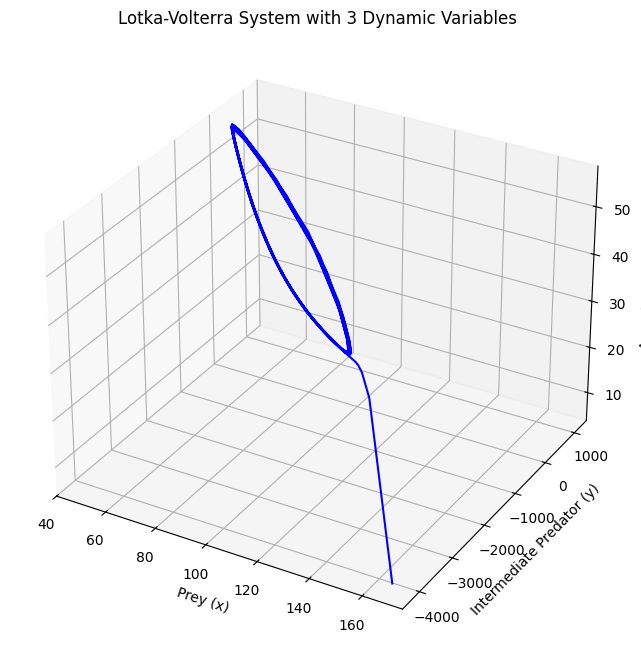

In [171]:
sol = lotka_volterra_model(y0=2, epsilon=7.5, time_span=5)

x_vals = sol[0]  # Prey population
y_vals = sol[1]  # Intermediate predator population
z_vals = sol[2]  # Apex predator population

# Plot the results in a 3D phase space
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# Plotting (x, y, z) - Prey, Intermediate Predator, Apex Predator in phase space
ax.plot(x_vals, y_vals, z_vals, lw=1.5, color="b")

# Labels and title
ax.set_xlabel("Prey (x)")
ax.set_ylabel("Intermediate Predator (y)")
ax.set_zlabel("Apex Predator (z)")
ax.set_title("Lotka-Volterra System with 3 Dynamic Variables")
plt.show()

In [172]:
x_vals.shape, y_vals.shape, z_vals.shape

((603,), (603,), (603,))

In [169]:
def normlize(series):
    series = series - series.min()
    return series / series.max()

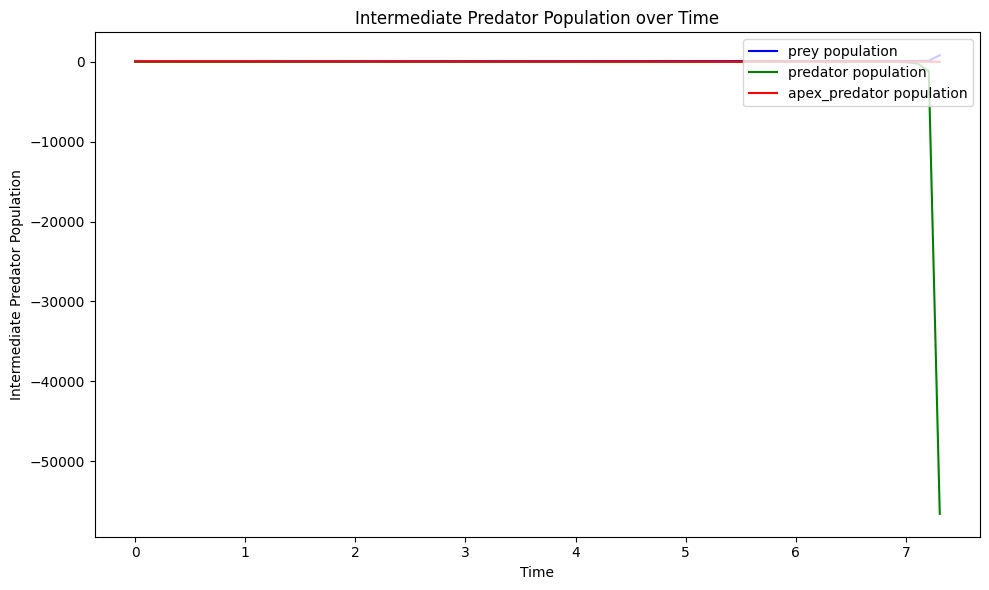

In [170]:
# Create plots for the 3 dynamic variables dependent on time

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot Prey population over time
ax.plot(t_eval[: x_vals.shape[0]], x_vals, lw=1.5, color="b", label="prey population")

# Plot Intermediate Predator population over time
ax.plot(
    t_eval[: x_vals.shape[0]], y_vals, lw=1.5, color="g", label="predator population"
)

# Plot Apex Predator population over time
ax.plot(
    t_eval[: x_vals.shape[0]],
    z_vals,
    lw=1.5,
    color="r",
    label="apex_predator population",
)


ax.set_title("Intermediate Predator Population over Time")
ax.set_xlabel("Time")
ax.set_ylabel("Intermediate Predator Population")

plt.legend(loc="upper right")
plt.tight_layout()
plt.show()